=== True Black-Box Adversarial Attacks on Clarifai API ===

🔧 Clarifai API Setup Required:
1. Go to https://clarifai.com/signup and create account
2. Go to https://clarifai.com/settings/security and get your API Key
3. Use the following defaults for the general model:
   - User ID: 'clarifai'
   - App ID: 'main'
   - Model ID: 'general-image-recognition'


Enter your Clarifai API Key:  8037e7e315804fc48e6b1d8cbb1b092c


Initializing Black-Box Model (Clarifai API)...
Loading Surrogate Model...
✓ Surrogate model (ResNet18) loaded
Creating Test Images...
✓ Created realistic test images

RUNNING BLACK-BOX ATTACKS

Testing API connection...
✓ API test successful: illustration (confidence: 0.985)

🔍 Executing Boundary Attack...
  Image 1 (red_object):
  Starting Boundary Attack...
    Original prediction: illustration (0.985)
    Query 1: Success! Prediction changed to disjunct
    Success: True, Queries: 3
  Image 2 (green_object):
  Starting Boundary Attack...
    Original prediction: disjunct (0.994)
    Query 2: Success! Prediction changed to empty
    Success: True, Queries: 4
  Image 3 (blue_object):
  Starting Boundary Attack...
    Original prediction: triangle (0.997)
    Query 10: Still triangle (0.997)
    Query 20: Still triangle (0.997)
    Query 30: Still triangle (0.997)
    Query 40: Still triangle (0.997)
    Query 50: Still triangle (0.997)
    Success: False, Queries: 52

🔍 Executing Nois

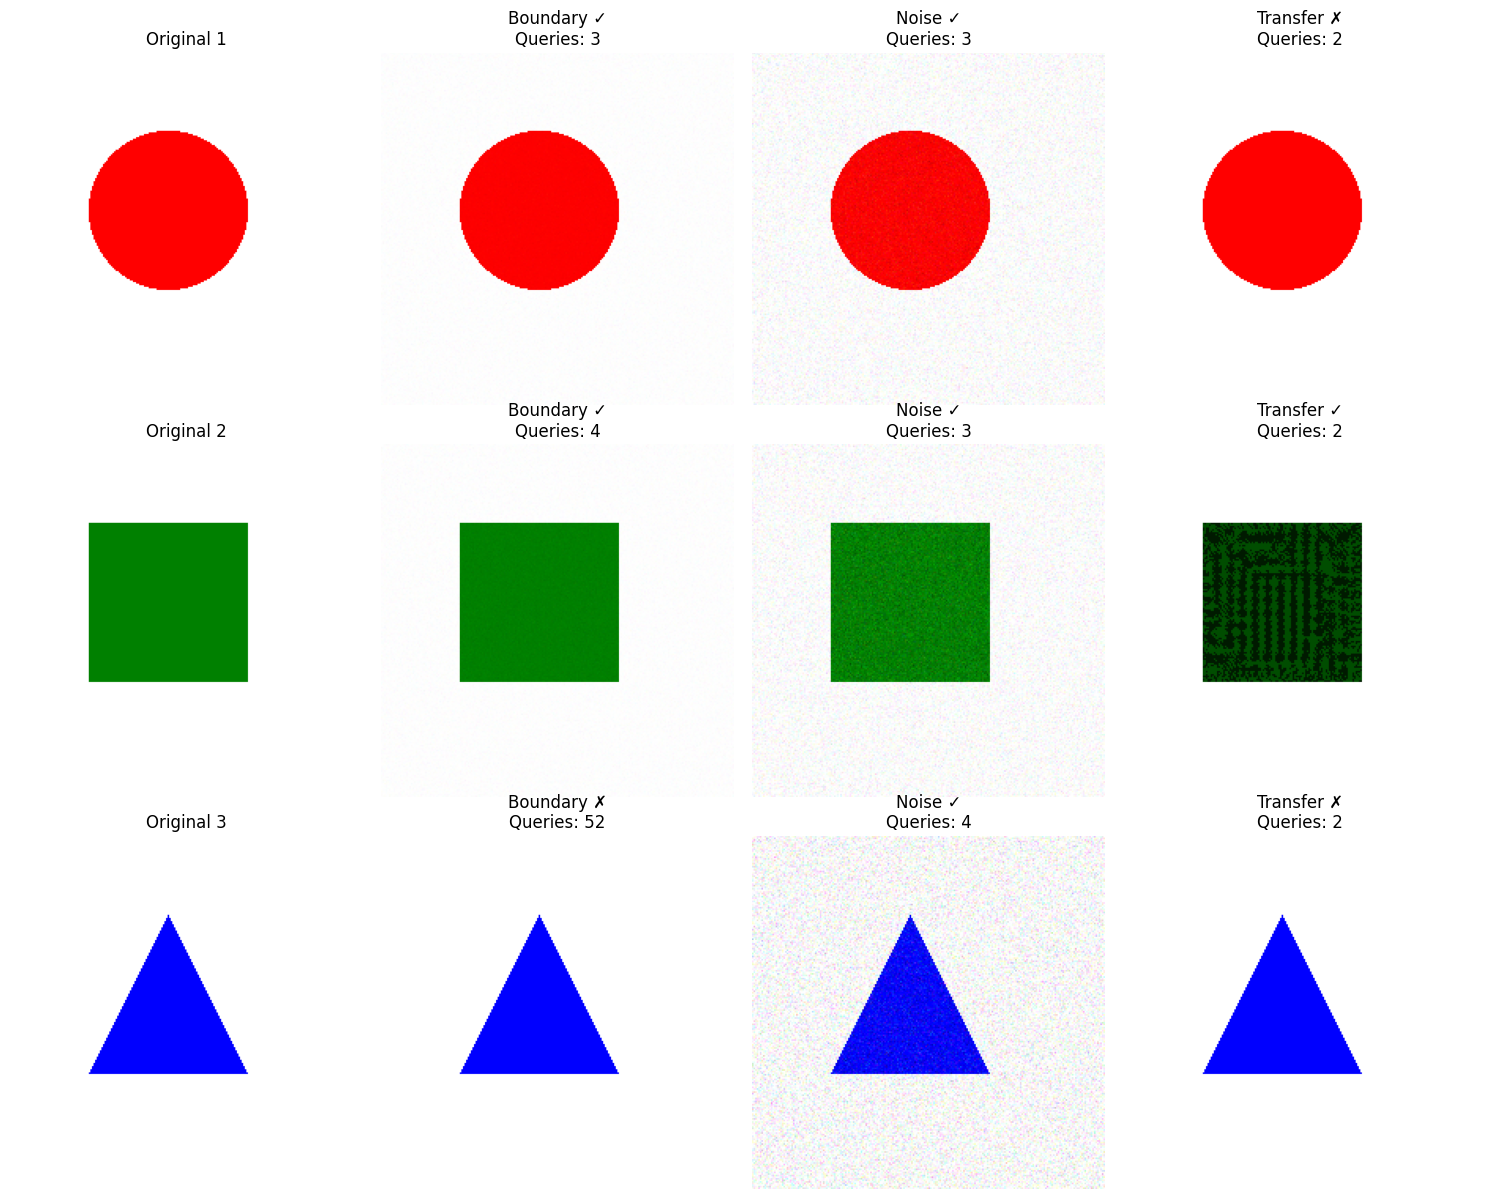

📈 Total API Queries: 2
🎯 Black-box attack demonstration completed!


In [9]:
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import numpy as np
from PIL import Image, ImageDraw
import requests
import json
import time
import matplotlib.pyplot as plt
from io import BytesIO
import base64

# Clarifai API setup - REPLACE WITH YOUR ACTUAL CREDENTIALS
CLARIFAI_API_KEY = "YOUR_API_KEY_HERE"  
CLARIFAI_USER_ID = "clarifai"  # Default for general model
CLARIFAI_APP_ID = "main"       # Default for general model
CLARIFAI_MODEL_ID = "general-image-recognition"  # Using Clarifai's general model

class ClarifaiBlackBoxModel:
    def __init__(self, api_key, user_id, app_id, model_id):
        self.api_key = api_key
        self.user_id = user_id
        self.app_id = app_id
        self.model_id = model_id
        # CORRECTED API URL FORMAT
        self.base_url = f"https://api.clarifai.com/v2/users/{user_id}/apps/{app_id}/models/{model_id}/outputs"
        self.headers = {
            "Authorization": f"Key {api_key}",
            "Content-Type": "application/json"
        }
        self.query_count = 0
        
    def predict(self, image):
        """Send image to Clarifai API and get predictions"""
        self.query_count += 1
        
        # Convert tensor to PIL Image if needed
        if isinstance(image, torch.Tensor):
            image = transforms.ToPILImage()(image.cpu())
        
        # Convert image to base64
        buffered = BytesIO()
        image.save(buffered, format="JPEG")
        img_str = base64.b64encode(buffered.getvalue()).decode()
        
        # CORRECTED REQUEST FORMAT
        data = {
            "inputs": [
                {
                    "data": {
                        "image": {
                            "base64": img_str
                        }
                    }
                }
            ]
        }
        
        try:
            response = requests.post(self.base_url, headers=self.headers, json=data)
            
            if response.status_code == 200:
                result = response.json()
                # EXTRACT PREDICTIONS SAFELY
                if 'outputs' in result and len(result['outputs']) > 0:
                    if 'data' in result['outputs'][0] and 'concepts' in result['outputs'][0]['data']:
                        concepts = result['outputs'][0]['data']['concepts']
                        
                        # Convert to probability distribution
                        probs = {}
                        for concept in concepts:
                            probs[concept['name']] = concept['value']
                        
                        return probs
                
                # If we can't extract concepts, return a default
                return {"unknown": 1.0}
            else:
                print(f"API error {response.status_code}: {response.text}")
                return {"error": 1.0}
                
        except Exception as e:
            print(f"Request failed: {e}")
            return {"error": 1.0}
    
    def get_query_count(self):
        return self.query_count
    
    def reset_query_count(self):
        self.query_count = 0

class SurrogateModel:
    def __init__(self):
        self.model = resnet18(pretrained=True)
        self.model.eval()
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
    def predict(self, image):
        if isinstance(image, Image.Image):
            image = self.transform(image).unsqueeze(0)
        
        with torch.no_grad():
            outputs = self.model(image)
            probabilities = torch.softmax(outputs, dim=1)
        
        return probabilities

def create_test_images():
    """Create simple test images"""
    images = []
    labels = []
    
    # Red circle
    img_red = Image.new('RGB', (224, 224), color='white')
    draw = ImageDraw.Draw(img_red)
    draw.ellipse([50, 50, 150, 150], fill='red')
    images.append(img_red)
    labels.append("red_object")
    
    # Green square
    img_green = Image.new('RGB', (224, 224), color='white')
    draw = ImageDraw.Draw(img_green)
    draw.rectangle([50, 50, 150, 150], fill='green')
    images.append(img_green)
    labels.append("green_object")
    
    # Blue triangle
    img_blue = Image.new('RGB', (224, 224), color='white')
    draw = ImageDraw.Draw(img_blue)
    draw.polygon([100, 50, 50, 150, 150, 150], fill='blue')
    images.append(img_blue)
    labels.append("blue_object")
    
    return images, labels

def boundary_attack(blackbox_model, original_image, target_class=None, max_queries=50):
    """Boundary attack implementation"""
    print("  Starting Boundary Attack...")
    
    original_pred = blackbox_model.predict(original_image)
    original_class = list(original_pred.keys())[0] if original_pred else "unknown"
    original_conf = list(original_pred.values())[0] if original_pred else 0.0
    print(f"    Original prediction: {original_class} ({original_conf:.3f})")
    
    best_adv = original_image
    best_confidence = original_conf
    
    for i in range(max_queries):
        # Add small random noise
        if isinstance(best_adv, Image.Image):
            adv_array = np.array(best_adv) / 255.0
        else:
            adv_array = best_adv.cpu().numpy().transpose(1, 2, 0)
        
        noise = np.random.normal(0, 0.01, adv_array.shape)
        perturbed_array = np.clip(adv_array + noise, 0, 1)
        
        if isinstance(best_adv, Image.Image):
            perturbed_img = Image.fromarray((perturbed_array * 255).astype(np.uint8))
        else:
            perturbed_tensor = torch.tensor(perturbed_array.transpose(2, 0, 1))
            perturbed_img = transforms.ToPILImage()(perturbed_tensor)
        
        # Query black-box model
        current_pred = blackbox_model.predict(perturbed_img)
        current_class = list(current_pred.keys())[0] if current_pred else "unknown"
        current_confidence = list(current_pred.values())[0] if current_pred else 0.0
        
        # Check if prediction changed (simple success condition)
        if current_class != original_class:
            best_adv = perturbed_img
            best_confidence = current_confidence
            print(f"    Query {i+1}: Success! Prediction changed to {current_class}")
            break
            
        if (i + 1) % 10 == 0:
            print(f"    Query {i+1}: Still {current_class} ({current_confidence:.3f})")
    
    final_pred = blackbox_model.predict(best_adv)
    final_class = list(final_pred.keys())[0] if final_pred else "unknown"
    success = final_class != original_class
    
    return best_adv, success, blackbox_model.get_query_count()

def noise_attack(blackbox_model, original_image, max_queries=15):
    """Simple noise-based attack"""
    print("  Starting Noise Attack...")
    
    original_pred = blackbox_model.predict(original_image)
    original_class = list(original_pred.keys())[0] if original_pred else "unknown"
    original_conf = list(original_pred.values())[0] if original_pred else 0.0
    print(f"    Original prediction: {original_class} ({original_conf:.3f})")
    
    best_adv = original_image
    
    for i in range(max_queries):
        # Convert to array and add noise
        if isinstance(original_image, Image.Image):
            img_array = np.array(original_image) / 255.0
        else:
            img_array = original_image.cpu().numpy().transpose(1, 2, 0)
        
        # Increase noise with each query
        noise_level = 0.05 * (i + 1)
        noise = np.random.normal(0, noise_level, img_array.shape)
        perturbed_array = np.clip(img_array + noise, 0, 1)
        
        if isinstance(original_image, Image.Image):
            perturbed_img = Image.fromarray((perturbed_array * 255).astype(np.uint8))
        else:
            perturbed_tensor = torch.tensor(perturbed_array.transpose(2, 0, 1))
            perturbed_img = transforms.ToPILImage()(perturbed_tensor)
        
        # Query model
        current_pred = blackbox_model.predict(perturbed_img)
        current_class = list(current_pred.keys())[0] if current_pred else "unknown"
        
        # Check for success
        if current_class != original_class:
            best_adv = perturbed_img
            print(f"    Query {i+1}: Success with noise level {noise_level:.3f}")
            break
    
    final_pred = blackbox_model.predict(best_adv)
    final_class = list(final_pred.keys())[0] if final_pred else "unknown"
    success = final_class != original_class
    
    return best_adv, success, blackbox_model.get_query_count()

def transfer_attack(surrogate_model, blackbox_model, original_image, max_queries=10):
    """Transfer attack using surrogate model"""
    print("  Starting Transfer Attack...")
    
    original_pred = blackbox_model.predict(original_image)
    original_class = list(original_pred.keys())[0] if original_pred else "unknown"
    original_conf = list(original_pred.values())[0] if original_pred else 0.0
    print(f"    Original prediction: {original_class} ({original_conf:.3f})")
    
    # Use surrogate model to generate adversarial example
    if isinstance(original_image, Image.Image):
        input_tensor = surrogate_model.transform(original_image).unsqueeze(0)
    else:
        input_tensor = original_image.unsqueeze(0)
    
    # Simple FGSM-like attack on surrogate
    input_tensor.requires_grad = True
    
    surrogate_output = surrogate_model.model(input_tensor)
    true_label = torch.argmax(surrogate_output, dim=1)
    
    # Target a different class (next class in Imagenet)
    target_label = (true_label + 1) % 1000
    loss = nn.CrossEntropyLoss()(surrogate_output, target_label)
    loss.backward()
    
    # Create adversarial example
    epsilon = 0.1
    perturbation = epsilon * input_tensor.grad.sign()
    adv_tensor = input_tensor + perturbation
    adv_tensor = torch.clamp(adv_tensor, 0, 1)
    
    # Convert back to PIL for black-box query
    adv_image = transforms.ToPILImage()(adv_tensor.squeeze(0).cpu())
    
    # Query black-box model
    adv_pred = blackbox_model.predict(adv_image)
    adv_class = list(adv_pred.keys())[0] if adv_pred else "unknown"
    
    success = adv_class != original_class
    
    return adv_image, success, blackbox_model.get_query_count()

def plot_results(original_images, attacked_images, results, filename='blackbox_attack_results.png'):
    """Plot attack results"""
    fig, axes = plt.subplots(3, 4, figsize=(15, 12))
    
    attack_names = ['Boundary', 'Noise', 'Transfer']
    
    for i, (orig_img, attack_results) in enumerate(zip(original_images, results)):
        # Original image
        axes[i, 0].imshow(orig_img)
        axes[i, 0].set_title(f'Original {i+1}')
        axes[i, 0].axis('off')
        
        # Attack results
        for j, attack_name in enumerate(attack_names):
            if j < len(attack_results):
                adv_img, success, queries = attack_results[j]
                axes[i, j+1].imshow(adv_img)
                status = "✓" if success else "✗"
                axes[i, j+1].set_title(f'{attack_name} {status}\nQueries: {queries}')
                axes[i, j+1].axis('off')
    
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

def get_clarifai_credentials():
    """Helper function to get Clarifai credentials"""
    print("🔧 Clarifai API Setup Required:")
    print("1. Go to https://clarifai.com/signup and create account")
    print("2. Go to https://clarifai.com/settings/security and get your API Key")
    print("3. Use the following defaults for the general model:")
    print("   - User ID: 'clarifai'")
    print("   - App ID: 'main'")
    print("   - Model ID: 'general-image-recognition'")
    
    api_key = input("Enter your Clarifai API Key: ").strip()
    
    if not api_key or api_key == "YOUR_API_KEY_HERE":
        print("❌ Please enter a valid API Key")
        return None
    
    return {
        'api_key': api_key,
        'user_id': 'clarifai', 
        'app_id': 'main',
        'model_id': 'general-image-recognition'
    }

def main():
    print("=== True Black-Box Adversarial Attacks on Clarifai API ===\n")
    
    # Get API credentials
    credentials = get_clarifai_credentials()
    if not credentials:
        return
    
    # Initialize models
    print("Initializing Black-Box Model (Clarifai API)...")
    blackbox_model = ClarifaiBlackBoxModel(
        credentials['api_key'],
        credentials['user_id'], 
        credentials['app_id'], 
        credentials['model_id']
    )
    
    print("Loading Surrogate Model...")
    surrogate_model = SurrogateModel()
    print("✓ Surrogate model (ResNet18) loaded")
    
    print("Creating Test Images...")
    test_images, test_labels = create_test_images()
    print("✓ Created realistic test images")
    
    print("\n" + "="*60)
    print("RUNNING BLACK-BOX ATTACKS")
    print("="*60 + "\n")
    
    # Test API connection
    print("Testing API connection...")
    test_pred = blackbox_model.predict(test_images[0])
    
    if "error" not in test_pred and test_pred:
        top_class = list(test_pred.keys())[0]
        top_conf = list(test_pred.values())[0]
        print(f"✓ API test successful: {top_class} (confidence: {top_conf:.3f})")
    else:
        print("✗ API test failed. Please check your API credentials.")
        print("Common issues:")
        print("  - Invalid API Key")
        print("  - Incorrect User ID/App ID") 
        print("  - Network connectivity issues")
        return
    
    blackbox_model.reset_query_count()
    
    # Store results for all attacks
    all_results = []
    
    # Run Boundary Attack
    print("\n🔍 Executing Boundary Attack...")
    boundary_results = []
    for i, (image, label) in enumerate(zip(test_images, test_labels)):
        print(f"  Image {i+1} ({label}):")
        blackbox_model.reset_query_count()
        adv_img, success, queries = boundary_attack(blackbox_model, image)
        boundary_results.append((adv_img, success, queries))
        print(f"    Success: {success}, Queries: {queries}")
    all_results.append(boundary_results)
    
    # Run Noise Attack  
    print("\n🔍 Executing Noise Attack...")
    noise_results = []
    for i, (image, label) in enumerate(zip(test_images, test_labels)):
        print(f"  Image {i+1} ({label}):")
        blackbox_model.reset_query_count()
        adv_img, success, queries = noise_attack(blackbox_model, image)
        noise_results.append((adv_img, success, queries))
        print(f"    Success: {success}, Queries: {queries}")
    all_results.append(noise_results)
    
    # Run Transfer Attack
    print("\n🔍 Executing Transfer Attack...")
    transfer_results = []
    for i, (image, label) in enumerate(zip(test_images, test_labels)):
        print(f"  Image {i+1} ({label}):")
        blackbox_model.reset_query_count()
        adv_img, success, queries = transfer_attack(surrogate_model, blackbox_model, image)
        transfer_results.append((adv_img, success, queries))
        print(f"    Success: {success}, Queries: {queries}")
    all_results.append(transfer_results)
    
    # Calculate metrics
    print("\n" + "="*60)
    print("ATTACK METRICS SUMMARY")
    print("="*60)
    
    attack_names = ["Boundary Attack", "Noise Attack", "Transfer Attack"]
    for name, results in zip(attack_names, all_results):
        success_rate = sum(1 for _, success, _ in results if success) / len(results) * 100
        avg_queries = sum(queries for _, _, queries in results) / len(results)
        
        print(f"\n{name}:")
        print(f"  ✅ Success Rate: {success_rate:.1f}%")
        print(f"  📊 Avg Queries: {avg_queries:.1f}")
    
    # Plot results
    print("\n📊 Generating results visualization...")
    plot_results(test_images, test_images, list(zip(*all_results)))
    
    total_queries = blackbox_model.get_query_count()
    print(f"📈 Total API Queries: {total_queries}")
    print("🎯 Black-box attack demonstration completed!")

if __name__ == "__main__":
    main()